<a href="https://colab.research.google.com/github/MaximilianoScarlato/PROYECTO_4-_REDES/blob/feature%2Feda-redes-v2/proyecto_4_Redes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📂 Por favor, sube tu archivo Excel:


Saving REDES 2014.xls to REDES 2014.xls
⏳ Cargando archivo...

✅ Columnas vacías eliminadas

🔄 Columnas renombradas:
['region', 'distrito', 'localidad', 'punto_muestreo', 'domicilio_extracción', 'sitio_extrac', 'macrocuenca', 'microcuenca', 'entidad', 'causa_extraccion', 'proyecto', 'fecha_muestreo', 'fecha_de_pasaje_a_estadisticos', 'número_de_muestra', 'mes', 'descripción_tipo_de_industria', '', 'arsénico_µg/l', '', 'arsénico_total_µg/l', '', 'nitratos_no3__mg/l', '', 'tetracloruro_de_carbono_µg/l', '', 'tricloroetileno_µg/l']

🗑️ Columnas eliminadas: ['sitio_extrac', 'macrocuenca', 'microcuenca', 'proyecto', '', 'arsénico_µg/l']

🎉 Estado FINAL del DataFrame con nuevo formato:
• Filas: 2970 | Columnas: 20
• Muestra de datos (primeras 2 filas):
            region            distrito localidad punto_muestreo domicilio_extracción entidad causa_extraccion       fecha_muestreo fecha_de_pasaje_a_estadisticos número_de_muestra             mes descripción_tipo_de_industria criterio  arsénic

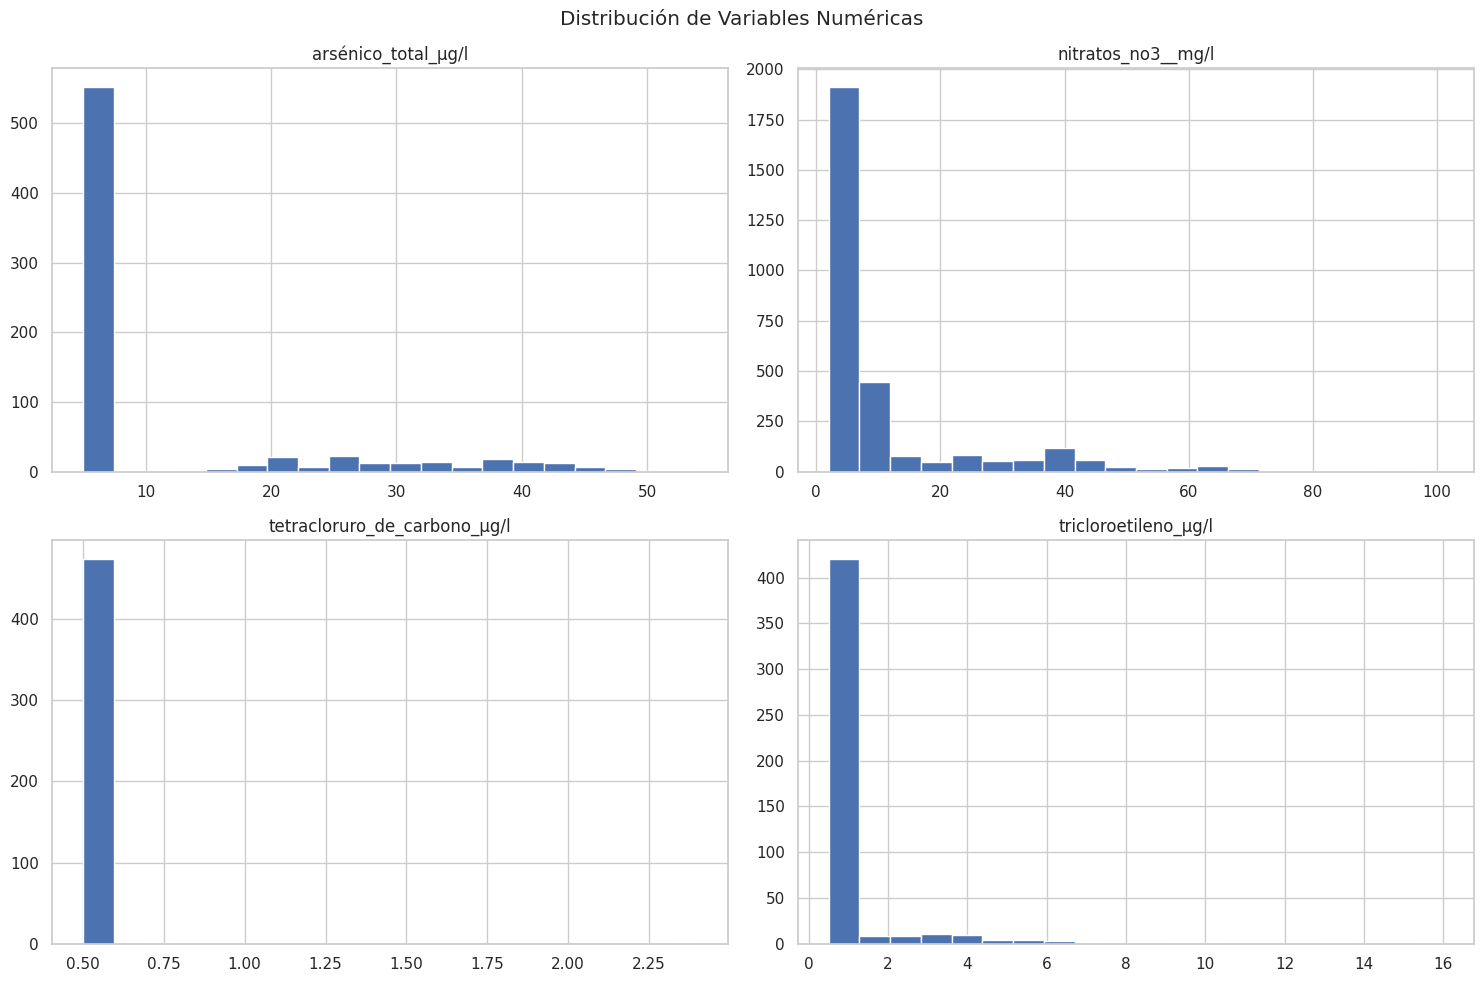

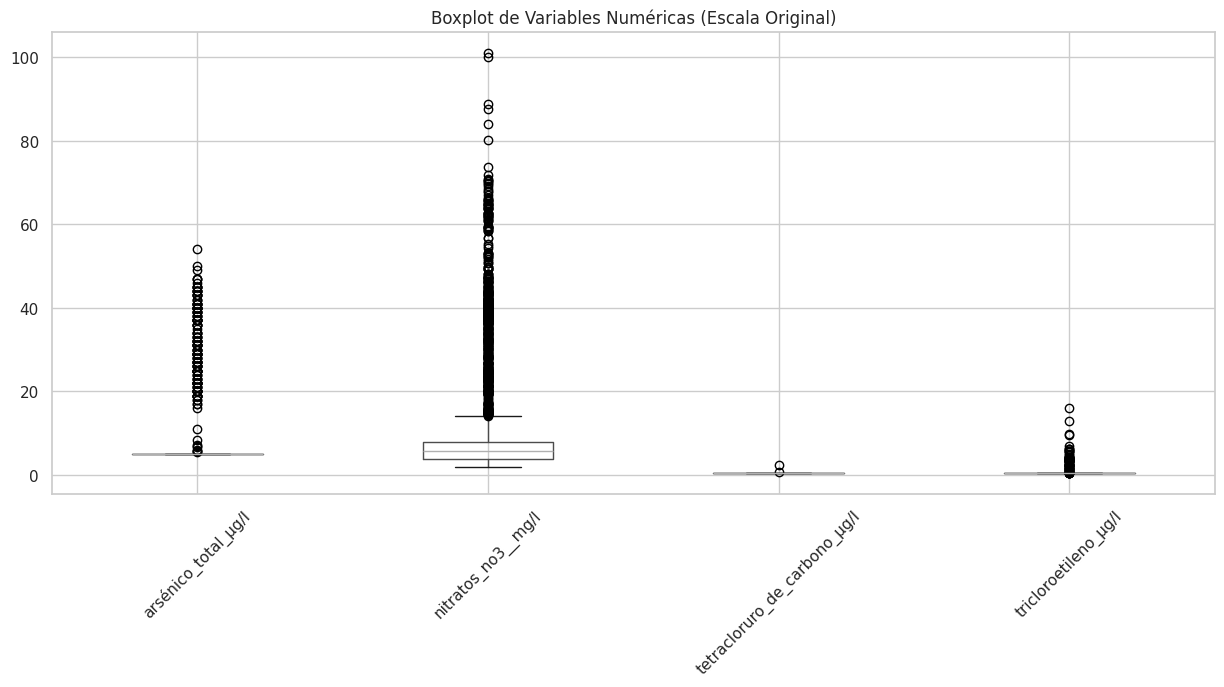


VISUALIZACIÓN DE DATOS



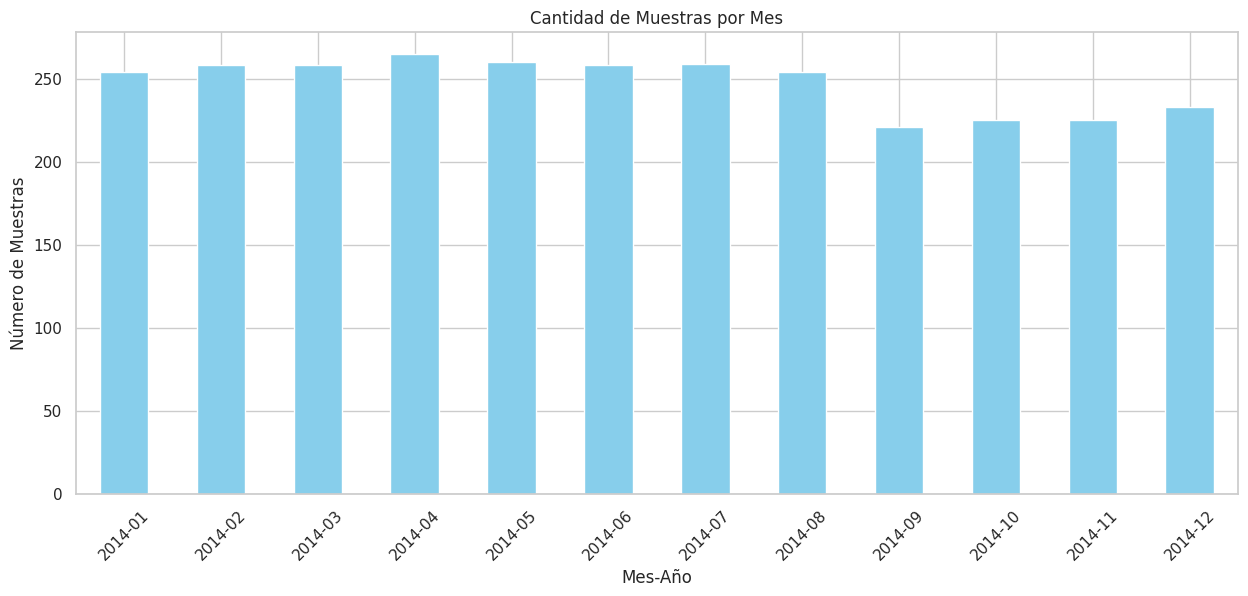


🎉 ¡Análisis completado con éxito!


In [1]:
# Importar librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

# Configuración inicial
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ---------------------------------------------------------------------------
# 1. Carga y limpieza inicial de datos
# ---------------------------------------------------------------------------
def cargar_y_limpiar_datos(ruta_archivo):
    """
    Carga el archivo Excel y realiza limpieza inicial:
    - Elimina filas/columnas vacías
    - Normaliza nombres de columnas
    - Maneja valores faltantes
    - Convierte tipos de datos
    - Reestructura el formato de salida según lo solicitado
    """
    print("⏳ Cargando archivo...")
    df = pd.read_excel(ruta_archivo, header=None)

    # Eliminar la primera fila (vacía)
    df = df.iloc[1:, :].reset_index(drop=True)

    # Combinar las filas 2 y 3 para crear encabezados
    headers_row_2 = df.iloc[0, :].fillna("")  # Fila 2
    headers_row_3 = df.iloc[1, :].fillna("")  # Fila 3
    combined_headers = headers_row_2 + " " + headers_row_3
    combined_headers = combined_headers.str.strip().str.replace(" +", " ", regex=True)  # Limpiar espacios

    # Asignar los encabezados combinados
    df.columns = combined_headers
    df = df.iloc[2:, :].reset_index(drop=True)  # Eliminar las filas 2 y 3

    # Eliminar columnas completamente vacías
    df = df.dropna(axis=1, how='all')
    print("\n✅ Columnas vacías eliminadas")

    # Renombrar columnas
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('-', '_').str.replace('unnamed', 'columna_sin_nombre')
    print("\n🔄 Columnas renombradas:")
    print(df.columns.tolist())

    # -----------------------------------------------------------------------
    # Eliminación de columnas específicas (por nombre para mayor seguridad)
    # -----------------------------------------------------------------------
    columnas_a_eliminar = ['sitio_extrac', 'macrocuenca', 'microcuenca', 'proyecto', '', 'arsénico_µg/l']
    columnas_a_eliminar = [col for col in columnas_a_eliminar if col in df.columns]

    df = df.drop(columns=columnas_a_eliminar, errors='ignore')
    print("\n🗑️ Columnas eliminadas:", columnas_a_eliminar)

    # -----------------------------------------------------------------------
    # Procesamiento específico para el formato solicitado
    # -----------------------------------------------------------------------
    # Columnas de información general que se mantendrán
    info_cols = ['region', 'distrito', 'localidad', 'punto_muestreo', 'domicilio_extracción',
                'entidad', 'causa_extraccion', 'fecha_muestreo', 'fecha_de_pasaje_a_estadisticos',
                'número_de_muestra', 'mes', 'descripción_tipo_de_industria']

    # Columnas objetivo para el nuevo formato
    target_cols = ['arsénico_total_µg/l', 'nitratos_no3__mg/l',
                 'tetracloruro_de_carbono_µg/l', 'tricloroetileno_µg/l']

    # Verificar que existan las columnas necesarias
    info_cols = [col for col in info_cols if col in df.columns]
    target_cols = [col for col in target_cols if col in df.columns]

    # Crear un nuevo DataFrame con las columnas de información
    new_df = df[info_cols].copy()

    # Procesar cada columna objetivo para extraer criterio y valor
    for col in target_cols:
        # Extraer criterio (primer caracter)
        new_df[f'criterio_{col}'] = df[col].astype(str).str[0].replace({'n': '<', 'N': '<', ',': '<', '.': '<'})

        # Extraer valor numérico
        new_df[col] = df[col].astype(str).str[1:].str.replace(',', '.').str.strip()

        # Manejar casos especiales donde el valor completo es numérico
        mask = ~new_df[f'criterio_{col}'].isin(['<', '='])
        new_df.loc[mask, col] = df.loc[mask, col].astype(str).str.replace(',', '.').str.strip()
        new_df.loc[mask, f'criterio_{col}'] = '='

        # Manejar casos donde el símbolo está después del número (ej: "5=")
        mixed_mask = df[col].astype(str).str.contains(r'^\d+[<=]', na=False)
        new_df.loc[mixed_mask, f'criterio_{col}'] = df.loc[mixed_mask, col].astype(str).str.extract(r'(\D)$')[0]
        new_df.loc[mixed_mask, col] = df.loc[mixed_mask, col].astype(str).str.extract(r'^(\d+)')[0]

        # Convertir a numérico
        new_df[col] = pd.to_numeric(new_df[col], errors='coerce')

    # Reordenar columnas según el formato solicitado
    ordered_cols = info_cols.copy()
    for col in target_cols:
        ordered_cols.append(f'criterio_{col}')
        ordered_cols.append(col)

    new_df = new_df[ordered_cols]

    # Renombrar columnas de criterio para que sean todas iguales
    for col in new_df.columns:
        if col.startswith('criterio_'):
            new_df = new_df.rename(columns={col: 'criterio'})

    # Reemplazar NaN en criterio con '<'
    new_df['criterio'] = new_df['criterio'].fillna('<')

    print("\n🎉 Estado FINAL del DataFrame con nuevo formato:")
    print(f"• Filas: {len(new_df)} | Columnas: {len(new_df.columns)}")
    print(f"• Muestra de datos (primeras 2 filas):")
    print(new_df.head(2).to_string())

    # Guardar archivo limpio temporal
    new_df.to_csv("datos_limpios_preview.csv", index=False)
    print("\n📁 Archivo temporal guardado: 'datos_limpios_preview.csv'")

    return new_df

# ---------------------------------------------------------------------------
# 2. Exportar datos limpios
# ---------------------------------------------------------------------------
def exportar_datos(df):
    """
    Exporta el DataFrame limpio a formatos XLSX y CSV.
    """
    try:
        output_xlsx_path = "archivo_limpio.xlsx"  # Ruta para el archivo .xlsx
        output_csv_path = "archivo_limpio.csv"  # Ruta para el archivo .csv

        # Guardar en formato Excel (.xlsx)
        df.to_excel(output_xlsx_path, index=False, engine="openpyxl")
        print(f"\n📁 Archivo limpio guardado en formato XLSX: {output_xlsx_path}")

        # Guardar en formato CSV
        df.to_csv(output_csv_path, index=False, encoding="utf-8-sig")
        print(f"📁 Archivo limpio guardado en formato CSV: {output_csv_path}")

    except Exception as e:
        print(f"❌ Error al exportar los datos: {e}")

# ---------------------------------------------------------------------------
# 3. Análisis Exploratorio de Datos (EDA)
# ---------------------------------------------------------------------------
def realizar_eda(df):
    """
    Realiza análisis exploratorio de datos:
    - Estadísticas descriptivas
    - Conteo de valores faltantes
    - Distribución de variables
    - Correlaciones
    """
    print("\n" + "="*80)
    print("ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
    print("="*80 + "\n")

    # Filtrar solo columnas numéricas para el análisis
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    print("📊 Información básica del dataset:")
    print(f"Total de registros: {len(df)}")
    print(f"Total de columnas: {len(df.columns)}")
    print("\nColumnas disponibles:")
    print(df.columns.tolist())

    print("\n📈 Estadísticas descriptivas para columnas numéricas:")
    print(df[numeric_cols].describe().transpose())

    print("\n🔍 Valores faltantes por columna:")
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum() / df.isnull().count() * 100).sort_values(ascending=False)
    missing_df = pd.concat([missing_data, missing_percent], axis=1, keys=['Total', 'Porcentaje'])
    print(missing_df[missing_df['Total'] > 0])

    if numeric_cols:
        print("\n📊 Distribución de variables numéricas:")
        df[numeric_cols].hist(bins=20, figsize=(15, 10))
        plt.suptitle('Distribución de Variables Numéricas')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(15, 6))
        df[numeric_cols].boxplot()
        plt.title('Boxplot de Variables Numéricas (Escala Original)')
        plt.xticks(rotation=45)
        plt.show()

# ---------------------------------------------------------------------------
# 4. Visualización de datos
# ---------------------------------------------------------------------------
def visualizar_datos(df):
    """
    Crea visualizaciones para explorar los datos:
    - Series temporales
    - Distribuciones geográficas
    - Comparaciones entre regiones
    """
    print("\n" + "="*80)
    print("VISUALIZACIÓN DE DATOS")
    print("="*80 + "\n")

    # Asegurarse de que 'fecha_muestreo' sea de tipo datetime
    if 'fecha_muestreo' in df.columns:
        df['fecha_muestreo'] = pd.to_datetime(df['fecha_muestreo'], errors='coerce')
        if df['fecha_muestreo'].notnull().any():
            df['año_mes'] = df['fecha_muestreo'].dt.to_period('M')
            conteo_muestras = df['año_mes'].value_counts().sort_index()

            plt.figure(figsize=(15, 6))
            conteo_muestras.plot(kind='bar', color='skyblue')
            plt.title('Cantidad de Muestras por Mes')
            plt.xlabel('Mes-Año')
            plt.ylabel('Número de Muestras')
            plt.xticks(rotation=45)
            plt.show()

# ---------------------------------------------------------------------------
# 5. Función principal
# ---------------------------------------------------------------------------
def main():
    """
    Función principal que ejecuta el flujo completo:
    1. Carga y limpieza de datos
    2. Exportación de datos limpios
    3. Análisis exploratorio
    4. Visualización de datos
    """
    from google.colab import files

    # Subir archivo
    print("📂 Por favor, sube tu archivo Excel:")
    uploaded = files.upload()
    ruta_archivo = list(uploaded.keys())[0]

    # 1. Cargar y limpiar datos
    df = cargar_y_limpiar_datos(ruta_archivo)

    # 2. Exportar datos limpios
    exportar_datos(df)

    # 3. Análisis exploratorio
    realizar_eda(df)

    # 4. Visualización de datos
    visualizar_datos(df)

    print("\n🎉 ¡Análisis completado con éxito!")

# Ejecutar función principal
if __name__ == "__main__":
    main()